<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# **Space X  Falcon 9 First Stage Landing Prediction**


## Hands on Lab: Complete the Machine Learning Prediction lab


Estimated time needed: **60** minutes


Space X advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because Space X can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against space X for a rocket launch.   In this lab, you will create a machine learning pipeline  to predict if the first stage will land given the data from the preceding labs.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/landing_1.gif)


Several examples of an unsuccessful landing are shown here:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/crash.gif)


Most unsuccessful landings are planed. Space X; performs a controlled landing in the oceans.


## Objectives


Perform exploratory  Data Analysis and determine Training Labels

*   create a column for the class
*   Standardize the data
*   Split into training data and test data

\-Find best Hyperparameter for SVM, Classification Trees and Logistic Regression

*   Find the method performs best using test data


## Import Libraries and Define Auxiliary Functions


In [1]:
import piplite
await piplite.install(['numpy'])
await piplite.install(['pandas'])
await piplite.install(['seaborn'])

We will import the following libraries for the lab


In [2]:
# Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# Matplotlib is a plotting library for python and pyplot gives us a MatLab like plotting framework. We will use this in our plotter function to plot data.
import matplotlib.pyplot as plt
#Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics
import seaborn as sns
# Preprocessing allows us to standarsize our data
from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV
# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier

<ipython-input-2-b7d446354769>:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


This function is to plot the confusion matrix.


In [3]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed']) 
    plt.show() 

## Load the dataframe


Load the data


In [4]:
from js import fetch
import io

URL1 = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"
resp1 = await fetch(URL1)
text1 = io.BytesIO((await resp1.arrayBuffer()).to_py())
data = pd.read_csv(text1)

In [6]:
data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [17]:
data.shape

(90, 18)

In [18]:
list(data.columns)

['FlightNumber',
 'Date',
 'BoosterVersion',
 'PayloadMass',
 'Orbit',
 'LaunchSite',
 'Outcome',
 'Flights',
 'GridFins',
 'Reused',
 'Legs',
 'LandingPad',
 'Block',
 'ReusedCount',
 'Serial',
 'Longitude',
 'Latitude',
 'Class']

In [19]:
URL2 = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv'
resp2 = await fetch(URL2)
text2 = io.BytesIO((await resp2.arrayBuffer()).to_py())
X = pd.read_csv(text2)

In [20]:
X.head(100)

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86.0,15400.000000,2.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
86,87.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
87,88.0,15400.000000,6.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
88,89.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


In [21]:
X.shape

(90, 83)

## TASK  1


Create a NumPy array from the column <code>Class</code> in <code>data</code>, by applying the method <code>to_numpy()</code>  then
assign it  to the variable <code>Y</code>,make sure the output is a  Pandas series (only one bracket df\['name of  column']).


In [27]:
Y = pd.Series(data['Class'].to_numpy())
Y.head(10)

0    0
1    0
2    0
3    0
4    0
5    0
6    1
7    1
8    0
9    0
dtype: int64

In [28]:
Y.shape

(90,)

In [29]:
Y

0     0
1     0
2     0
3     0
4     0
     ..
85    1
86    1
87    1
88    1
89    1
Length: 90, dtype: int64

## TASK  2


Standardize the data in <code>X</code> then reassign it to the variable  <code>X</code> using the transform provided below.


In [30]:
# students get this 
transform = preprocessing.StandardScaler()
X = transform.fit(X).transform(X)
X[0:1]

array([[-1.71291154e+00, -1.94814463e-16, -6.53912840e-01,
        -1.57589457e+00, -9.73440458e-01, -1.05999788e-01,
        -1.05999788e-01, -6.54653671e-01, -1.05999788e-01,
        -5.51677284e-01,  3.44342023e+00, -1.85695338e-01,
        -3.33333333e-01, -1.05999788e-01, -2.42535625e-01,
        -4.29197538e-01,  7.97724035e-01, -5.68796459e-01,
        -4.10890702e-01, -4.10890702e-01, -1.50755672e-01,
        -7.97724035e-01, -1.50755672e-01, -3.92232270e-01,
         9.43398113e+00, -1.05999788e-01, -1.05999788e-01,
        -1.05999788e-01, -1.05999788e-01, -1.05999788e-01,
        -1.05999788e-01, -1.05999788e-01, -1.05999788e-01,
        -1.05999788e-01, -1.05999788e-01, -1.05999788e-01,
        -1.05999788e-01, -1.05999788e-01, -1.05999788e-01,
        -1.05999788e-01, -1.05999788e-01, -1.05999788e-01,
        -1.05999788e-01, -1.50755672e-01, -1.05999788e-01,
        -1.05999788e-01, -1.05999788e-01, -1.05999788e-01,
        -1.05999788e-01, -1.50755672e-01, -1.05999788e-0

We split the data into training and testing data using the  function  <code>train_test_split</code>.   The training data is divided into validation data, a second set used for training  data; then the models are trained and hyperparameters are selected using the function <code>GridSearchCV</code>.


## TASK  3


Use the function train_test_split to split the data X and Y into training and test data. Set the parameter test_size to  0.2 and random_state to 2. The training data and test data should be assigned to the following labels.


<code>X_train, X_test, Y_train, Y_test</code>


In [31]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

we can see we only have 18 test samples.


In [32]:
print(f'X_train: {X_train.shape}  Y_train: {Y_train.shape}')
print(f'X_test: {X_test.shape}  Y_test: {Y_test.shape}')

X_train: (72, 83)  Y_train: (72,)
X_test: (18, 83)  Y_test: (18,)


## TASK  4


Create a logistic regression object  then create a  GridSearchCV object  <code>logreg_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [33]:
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'],
             'solver':['lbfgs']}

In [42]:
parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge
lr=LogisticRegression()

logreg_cv=GridSearchCV(lr, parameters, cv=10)
logreg_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

We output the <code>GridSearchCV</code> object for logistic regression. We display the best parameters using the data attribute <code>best_params\_</code> and the accuracy on the validation data using the data attribute <code>best_score\_</code>.


In [43]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8464285714285713


In [44]:
# Set parameters, create model, perform GridSearchCV to identify the best parameters, and train model on training data.
parameters_lr = {"C":[0.01,0.1,1],
                 'penalty':['l2'],
                 'solver':['lbfgs']}  # l1 lasso l2 ridge

lr = LogisticRegression()
logreg_cv = GridSearchCV(lr, parameters_lr, cv=10)
logreg_cv.fit(X_train, Y_train)
print("Tuned Hyperparameters (Best Parameters): ", logreg_cv.best_params_)
print("Accuracy: ", logreg_cv.best_score_)

Tuned Hyperparameters (Best Parameters):  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy:  0.8464285714285713


## TASK  5


Calculate the accuracy on the test data using the method <code>score</code>:


In [45]:
logreg_accuracy = logreg_cv.score(X_test, Y_test)
logreg_accuracy

0.8333333333333334

Lets look at the confusion matrix:


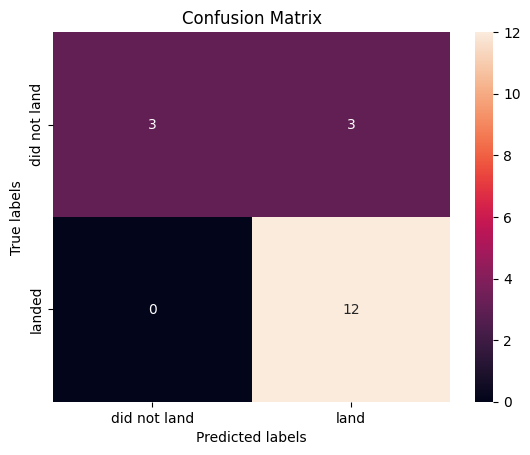

In [46]:
yhat=logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

Examining the confusion matrix, we see that logistic regression can distinguish between the different classes.  We see that the problem is false positives.

Overview:

True Postive - 12 (True label is landed, Predicted label is also landed)

False Postive - 3 (True label is not landed, Predicted label is landed)


## TASK  6


Create a support vector machine object then  create a  <code>GridSearchCV</code> object  <code>svm_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [53]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()

In [55]:
svm_cv = GridSearchCV(svm, parameters, cv=10)
svm_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')})

In [57]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
accuracy : 0.8482142857142856


## TASK  7


Calculate the accuracy on the test data using the method <code>score</code>:


In [58]:
svm_accuracy = svm_cv.score(X_test, Y_test)
svm_accuracy

0.8333333333333334

We can plot the confusion matrix


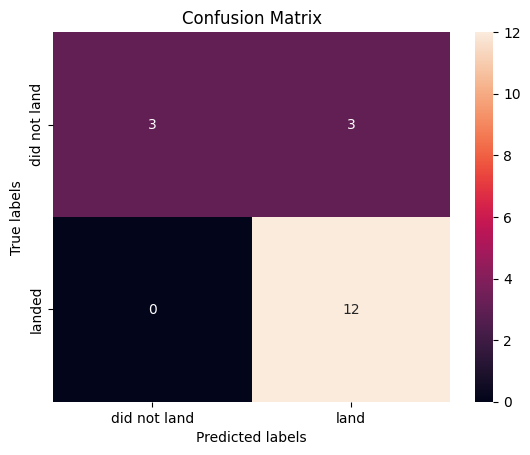

In [59]:
yhat=svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

## TASK  8


Create a decision tree classifier object then  create a  <code>GridSearchCV</code> object  <code>tree_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [102]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()
tree_cv = GridSearchCV(tree, parameters, cv=10)
tree_cv.fit(X_train, Y_train)
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)


/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
3240 fits failed out of a total of 6480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3240 fits failed with the following error:
Traceback (most recent call last):
  File "/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/lib/python3.12/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/lib/python3.12/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_p

tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'splitter': 'random'}
accuracy : 0.8875


## TASK  9


Calculate the accuracy of tree_cv on the test data using the method <code>score</code>:


In [103]:
acc_tree_test_data = tree_cv.score(X_test, Y_test)
print("Accuracy on test data :", acc_tree_test_data)

Accuracy on test data : 0.8333333333333334


In [104]:
print("accuracy :", tree_cv.score(X_test, Y_test))

accuracy : 0.8333333333333334


In [105]:
tree_accuracy = tree_cv.score(X_test, Y_test)
tree_accuracy

0.8333333333333334

We can plot the confusion matrix


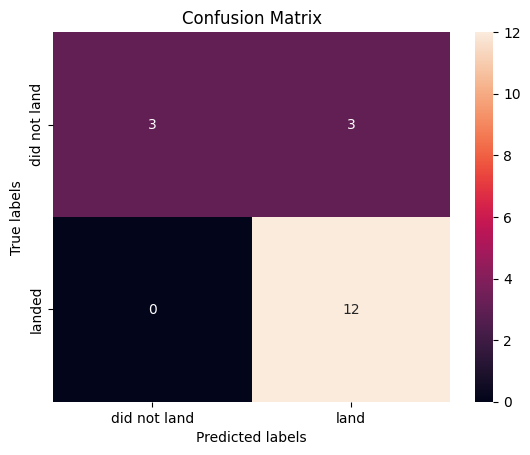

In [106]:
yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

## TASK  10


Create a k nearest neighbors object then  create a  <code>GridSearchCV</code> object  <code>knn_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [73]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

In [74]:
knn_cv = GridSearchCV(KNN, parameters, cv=10)
knn_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]})

In [75]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1}
accuracy : 0.8482142857142858


In [76]:
parameters_knn = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, parameters_knn, cv=10)
knn_cv.fit(X_train, Y_train)
print("Tuned Hyperparameters (Best Parameters): ", knn_cv.best_params_)
print("Accuracy: ", knn_cv.best_score_)

Tuned Hyperparameters (Best Parameters):  {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1}
Accuracy:  0.8482142857142858


## TASK  11


Calculate the accuracy of knn_cv on the test data using the method <code>score</code>:


In [77]:
knn_accuracy = knn_cv.score(X_test, Y_test)
knn_accuracy

0.8333333333333334

We can plot the confusion matrix


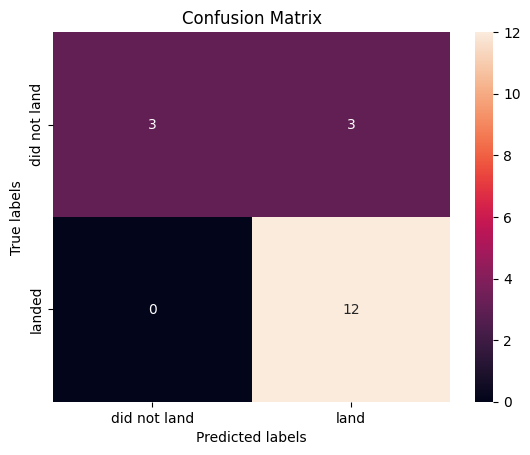

In [78]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

## TASK  12


Find the method performs best:


In [94]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import jaccard_score, f1_score, accuracy_score
import pandas as pd
import numpy as np

# Train your models using the training data (X_train, Y_train)
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)  # Train the Logistic Regression model

svm = SVC()
svm.fit(X_train, Y_train)  # Train the SVM model

tree = DecisionTreeClassifier()
tree.fit(X_train, Y_train)  # Train the Decision Tree model

knn = KNeighborsClassifier()
knn.fit(X_train, Y_train)  # Train the KNN model

logreg_yhat = logreg.predict(X_test)
svm_yhat = svm.predict(X_test)
tree_yhat = tree.predict(X_test)

knn_yhat = knn.predict(X_test)
# Calculate evaluation metrics
jaccard_scores = [
    jaccard_score(Y_test, logreg_yhat, average='binary'),
    jaccard_score(Y_test, svm_yhat, average='binary'),
    jaccard_score(Y_test, tree_yhat, average='binary'),
    jaccard_score(Y_test, knn_yhat, average='binary'),
]

f1_scores = [
    f1_score(Y_test, logreg_yhat, average='binary'),
    f1_score(Y_test, svm_yhat, average='binary'),
    f1_score(Y_test, tree_yhat, average='binary'),
    f1_score(Y_test, knn_yhat, average='binary'),
]

# Calculate accuracy
logreg_accuracy = accuracy_score(Y_test, logreg_yhat)
svm_accuracy = accuracy_score(Y_test, svm_yhat)
tree_accuracy = accuracy_score(Y_test, tree_yhat)
knn_accuracy = accuracy_score(Y_test, knn_yhat)

accuracy = [logreg_accuracy, svm_accuracy, tree_accuracy, knn_accuracy]

# Create the DataFrame to visualize the scores
scores = pd.DataFrame(np.array([jaccard_scores, f1_scores, accuracy]), 
                      index=['Jaccard_Score', 'F1_Score', 'Accuracy'],
                      columns=['LogReg', 'SVM', 'Tree', 'KNN'])

# Print the DataFrame
print(scores)

                 LogReg       SVM      Tree       KNN
Jaccard_Score  0.800000  0.733333  0.846154  0.750000
F1_Score       0.888889  0.846154  0.916667  0.857143
Accuracy       0.833333  0.777778  0.888889  0.777778


In [95]:
# Examining the scores from the whole Dataset
jaccard_scores = [
                  jaccard_score(Y, logreg_cv.predict(X), average='binary'),
                  jaccard_score(Y, svm_cv.predict(X), average='binary'),
                  jaccard_score(Y, tree_cv.predict(X), average='binary'),
                  jaccard_score(Y, knn_cv.predict(X), average='binary'),
                 ]

f1_scores = [
             f1_score(Y, logreg_cv.predict(X), average='binary'),
             f1_score(Y, svm_cv.predict(X), average='binary'),
             f1_score(Y, tree_cv.predict(X), average='binary'),
             f1_score(Y, knn_cv.predict(X), average='binary'),
            ]

accuracy = [logreg_cv.score(X, Y), svm_cv.score(X, Y), tree_cv.score(X, Y), knn_cv.score(X, Y)]

scores = pd.DataFrame(np.array([jaccard_scores, f1_scores, accuracy]),
                      index=['Jaccard_Score', 'F1_Score', 'Accuracy'],
                      columns=['LogReg', 'SVM', 'Tree', 'KNN'])
scores

,LogReg,SVM,Tree,KNN
Jaccard_Score,0.833333,0.845070,0.740260,0.819444
F1_Score,0.909091,0.916031,0.850746,0.900763
Accuracy,0.866667,0.877778,0.777778,0.855556


In [ ]:
Conclusion
Based on the scores of the Test Set, we can not confirm which method perfoms best.
Same Test Set scores may be due to the small test sample size (18 samples). Therefore, we tested all methods based on the whole Dataset.
The scores of the whole Dataset confirm that the best model is the Decision Tree Model. This model has not only higher scores, but also the highest accuracy.

In [96]:
print("Model\t\tAccuracy\tTestAccuracy")

# Round the float values using the Python built-in round function
print("LogReg\t\t{}\t\t{}".format(round(logreg_cv.best_score_, 5), round(logreg_cv.score(X_test, Y_test), 5)))
print("SVM\t\t{}\t\t{}".format(round(svm_cv.best_score_, 5), round(svm_cv.score(X_test, Y_test), 5)))
print("Tree\t\t{}\t\t{}".format(round(tree_cv.best_score_, 5), round(tree_cv.score(X_test, Y_test), 5)))
print("KNN\t\t{}\t\t{}".format(round(knn_cv.best_score_, 5), round(knn_cv.score(X_test, Y_test), 5)))

# Create comparison dictionary
comparison = {}

comparison['LogReg'] = {'Accuracy': round(logreg_cv.best_score_, 5), 'TestAccuracy': round(logreg_cv.score(X_test, Y_test), 5)}
comparison['SVM'] = {'Accuracy': round(svm_cv.best_score_, 5), 'TestAccuracy': round(svm_cv.score(X_test, Y_test), 5)}
comparison['Tree'] = {'Accuracy': round(tree_cv.best_score_, 5), 'TestAccuracy': round(tree_cv.score(X_test, Y_test), 5)}
comparison['KNN'] = {'Accuracy': round(knn_cv.best_score_, 5), 'TestAccuracy': round(knn_cv.score(X_test, Y_test), 5)}

print(comparison)

Model		Accuracy	TestAccuracy
LogReg		0.84643		0.83333
SVM		0.84821		0.83333
Tree		0.88571		0.94444
KNN		0.84821		0.83333
{'LogReg': {'Accuracy': 0.84643, 'TestAccuracy': 0.83333}, 'SVM': {'Accuracy': 0.84821, 'TestAccuracy': 0.83333}, 'Tree': {'Accuracy': 0.88571, 'TestAccuracy': 0.94444}, 'KNN': {'Accuracy': 0.84821, 'TestAccuracy': 0.83333}}


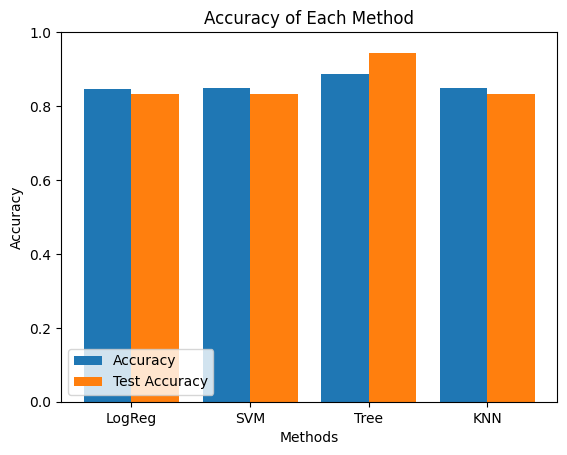

In [97]:
x = []
y1 = []
y2 = []
for meth in comparison.keys():
    x.append(meth)    
    y1.append(comparison[meth]['Accuracy'])
    y2.append(comparison[meth]['TestAccuracy'])
    

x_axis = np.arange(len(x))

plt.bar(x_axis - 0.2, y1, 0.4, label = 'Accuracy')
plt.bar(x_axis + 0.2, y2, 0.4, label = 'Test Accuracy')

plt.ylim([0,1])
plt.xticks(x_axis, x)

plt.xlabel("Methods")
plt.ylabel("Accuracy")
plt.title("Accuracy of Each Method")
plt.legend(loc='lower left')
plt.show()
    

In [98]:
# Since their accuracies are all the same, we pick based on their best scores
algo_score = {'Logistic regresssion': [logreg_cv.best_score_], 'SVM': [svm_cv.best_score_], 'Decision tree': [tree_cv.best_score_], 'KNN': [knn_cv.best_score_]}
df = pd.DataFrame.from_dict(algo_score, orient='index', columns=['Best scores'])
df

,Best scores
Logistic regresssion,0.846429
SVM,0.848214
Decision tree,0.885714
KNN,0.848214


In [99]:
algo_score = {'Logistic regression': [logreg_cv.best_score_], 
              'SVM': [svm_cv.best_score_], 
              'Decision tree': [tree_cv.best_score_], 
              'KNN': [knn_cv.best_score_]}

df = pd.DataFrame.from_dict(algo_score, orient='index', columns=['Best scores'])

# Now access the 'Best scores' column to find the best method
best_method = df['Best scores'].idxmax()  # This will return the name of the method with the highest score

print("The best method is:", best_method)

The best method is: Decision tree


In [100]:
# Compile model scores into a DataFrame and then identify and label the maximum score
ranking_dict = {'Model':['Logistic Regression', 'SVM', 'Decision Tree', 'KNN'], 'Score':[logreg_accuracy, svm_accuracy, tree_accuracy, knn_accuracy]}
ranking_df = pd.DataFrame(ranking_dict)

def assign_status(score):
    if score == ranking_df['Score'].max():
        return 'Max Score'
    else:
        return '0'

ranking_df['Max Score'] = ranking_df['Score'].apply(assign_status)
ranking_df

,Model,Score,Max Score
0,Logistic Regression,0.833333,0
1,SVM,0.777778,0
2,Decision Tree,0.888889,Max Score
3,KNN,0.777778,0


<ipython-input-101-3c3bec3deafa>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(kind="bar", data=ranking_df, x="Model", y="Score", aspect=2, palette=colors_dict)


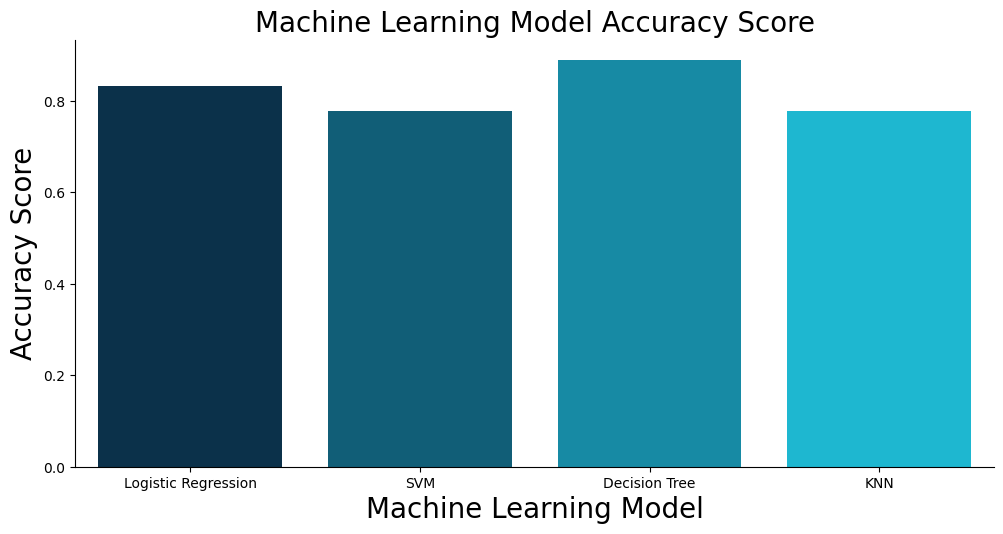

In [101]:
# Plot the model accuracy on a bar chart
colors_dict = {'Logistic Regression':'#003355', 'SVM':'#006688', 'Decision Tree':'#0099bb', 'KNN':'#00ccee'}
sns.catplot(kind="bar", data=ranking_df, x="Model", y="Score", aspect=2, palette=colors_dict)
plt.xlabel("Machine Learning Model", fontsize=20)
plt.ylabel("Accuracy Score", fontsize=20)
plt.title("Machine Learning Model Accuracy Score", fontsize=20)
plt.show()

In [ ]:
The best method is: Decision tree

## Authors


[Pratiksha Verma](https://www.linkedin.com/in/pratiksha-verma-6487561b1/)


<!--## Change Log--!>


<!--| Date (YYYY-MM-DD) | Version | Changed By      | Change Description      |
| ----------------- | ------- | -------------   | ----------------------- |
| 2022-11-09        | 1.0     | Pratiksha Verma | Converted initial version to Jupyterlite|--!>


### <h3 align="center"> IBM Corporation 2022. All rights reserved. <h3/>
